In [42]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2, VGG16
from keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
import numpy as np
import keras_tuner as kt
import pandas as pd
from PIL import Image
import cv2 as cv
import pillow_heif
from deepface import DeepFace
import os
from collections import Counter

In [2]:
tf.config.list_physical_devices('GPU') # Check if GPU is available

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
def batch_heic_to_png(input_folder, output_folder):
    # Ensure the output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate over all files in the input folder
    for filename in os.listdir(input_folder):
        if filename.lower().endswith(".heic"):
            input_path = os.path.join(input_folder, filename)
            output_filename = os.path.splitext(filename)[0] + ".jpg"
            output_path = os.path.join(output_folder, output_filename)
            
            try:
                # Open HEIC image and save as JPEG
                heif_image = pillow_heif.open_heif(input_path)
                image = Image.frombytes(
                    heif_image.mode, 
                    heif_image.size, 
                    heif_image.data
                )
                image = image.resize((224,224))
                image = image.convert("L")
                image.save(output_path, format="JPEG", quality = 100)
            except Exception as e:
                print(f"Failed to convert {input_path}: {e}")

In [4]:
#Input folders for datasets
input_folder_happy = './Image Processing Dataset/Happy'
input_folder_sad = './Image Processing Dataset/Sad'

In [5]:
#Processed images will be output here
output_folder_happy = './Image Processing Dataset/Converted_Images/faces/Happy'
output_folder_sad = './Image Processing Dataset/Converted_Images/faces/Sad'

In [6]:
batch_heic_to_png(input_folder_happy, output_folder_happy)
batch_heic_to_png(input_folder_sad, output_folder_sad)

In [7]:
# Define the directory containing your images
input_dir_happy2 = './Image Processing Dataset/Happy2'
input_dir_sad2 = './Image Processing Dataset/Sad2'
# Create the output directory if it doesn't exist
def img_preprocessing(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    # Process each image in the input directory
    for filename in os.listdir(input_dir):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            # Open the image file
            with Image.open(os.path.join(input_dir, filename)) as img:
                # Resize image to 224x224
                img = img.resize((224, 224), Image.LANCZOS)
                # Convert image to greyscale
                img = img.convert('L')
                # Save the processed image
                img.save(os.path.join(output_dir, filename))

print("All images have been processed and saved.")

All images have been processed and saved.


In [8]:
img_preprocessing(input_dir_happy2, output_folder_happy)
img_preprocessing(input_dir_sad2, output_folder_sad)

In [9]:
training_path = './Image Processing Dataset/Converted_Images/faces'

In [10]:
classes=[]
paths=[]
images=[]
for dirname, _, filenames in os.walk(training_path):
    for filename in filenames:
        if filename.lower().endswith('.jpg'):
            class_name=(dirname.split('\\')[-1])
            file_path=os.path.join(dirname, filename)
            paths.append(file_path)
            classes.append(class_name)

In [11]:
print(len(classes))

15117


In [12]:
N=list(range(len(classes)))
class_names=sorted(set(classes))
print(class_names)
normal_mapping=dict(zip(class_names,N)) 
reverse_mapping=dict(zip(N,class_names))       

df=pd.DataFrame(columns=['path','class','label'])
df['path']=paths
df['class']=classes
df['label']=df['class'].map(normal_mapping)
print(len(df))

['Happy', 'Sad']
15117


In [15]:
print('number of samples: ', len(df['class']))
print('keys: ', list(df.keys()))
print('image shape: ', df.shape)
print('labels:', np.unique(df['class']))

number of samples:  15117
keys:  ['path', 'class', 'label']
image shape:  (15117, 3)
labels: ['Happy' 'Sad']


In [16]:
#image size, batch and validation split
batch_size = 32
img_size = (224,224)
validation_split = 0.3

In [17]:
#dataset split
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    training_path,
    validation_split=validation_split,
    labels='inferred',
    subset="training",
    seed=123,
    shuffle=True,
    image_size=img_size,
    batch_size=batch_size
)

Found 15117 files belonging to 2 classes.
Using 10582 files for training.


In [18]:
#validation split
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    training_path,
    validation_split=validation_split,
    labels='inferred',
    subset="validation",
    shuffle=True,
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

Found 15117 files belonging to 2 classes.
Using 4535 files for validation.


In [19]:
#validation set split in half for validation and test
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 2)
validation_dataset = validation_dataset.skip(val_batches // 2)

In [20]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 71
Number of test batches: 71


In [45]:
def count_class_distribution(dataset):
    class_counts = Counter()
    for images, labels in dataset:
        class_counts.update(labels.numpy())
    return class_counts

# Count class distribution in training and validation datasets
train_class_distribution = count_class_distribution(train_dataset)
val_class_distribution = count_class_distribution(validation_dataset)
test_class_distribution = count_class_distribution(test_dataset)

# Print the class distribution
print("Training dataset class distribution:")
for class_label, count in train_class_distribution.items():
    print(f"Class {class_label}: {count} samples")

print("\nValidation dataset class distribution:")
for class_label, count in val_class_distribution.items():
    print(f"Class {class_label}: {count} samples")

print("\nTest dataset class distribution:")
for class_label, count in test_class_distribution.items():
    print(f"Class {class_label}: {count} samples")

Training dataset class distribution:
Class 0: 6301 samples
Class 1: 4281 samples

Validation dataset class distribution:
Class 1: 907 samples
Class 0: 1356 samples

Test dataset class distribution:
Class 0: 1349 samples
Class 1: 923 samples


In [21]:
AUTOTUNE = tf.data.AUTOTUNE

In [22]:
#one hot encoding
def preprocess_dataset(dataset):
    def one_hot_encode(image, label):
        label = tf.cast(label, tf.int32)
        label = tf.one_hot(label, depth=2)
        return image, label
    return dataset.map(one_hot_encode)

train_ds = preprocess_dataset(train_dataset)
val_ds = preprocess_dataset(validation_dataset)
test_ds = preprocess_dataset(test_dataset)

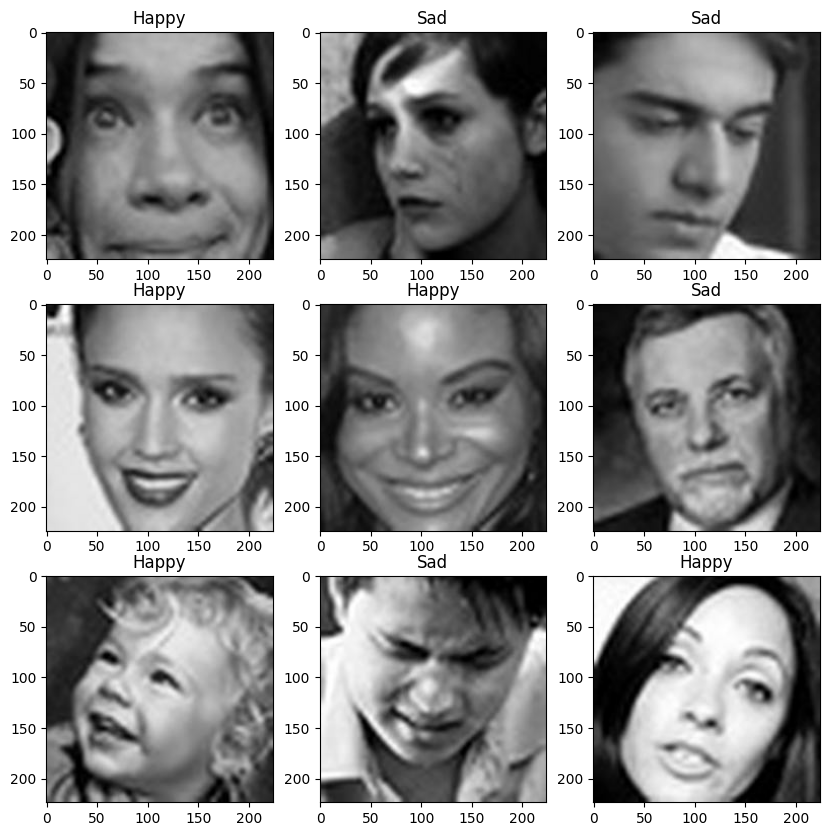

In [23]:
#dataset visualization
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i].numpy().argmax()])

In [24]:
#Data augmentation
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(224,224, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [25]:
#EfficientNet model with frozen layers and imagenet weights
IMG_SHAPE = img_size + (3,)
base_model = tf.keras.applications.EfficientNetB0(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [26]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0][0

In [27]:
for layer in base_model.layers:
    layer.trainable = False

In [28]:
#Final model with hyperparameter tuning options
def model_tuner(hp):
    my_model = models.Sequential([
                                data_augmentation,

                                base_model,

                                layers.GlobalAveragePooling2D(),

                                Dense(hp.Int('Dense_1', min_value=128, max_value=512, step=128), activation='relu'),

                                BatchNormalization(),
                                
                                Dropout(hp.Float('Dropout_1', min_value=0.2,max_value=0.6,step=0.1)),

                                layers.Dense(2, activation='softmax')])
    my_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return my_model


In [29]:
#keras tuning and hyperparameter tuning
tuner = kt.Hyperband(
    model_tuner,
    objective='val_accuracy',
    max_epochs=25,
    factor=3,
    directory='hyperparam_tuning',
    project_name='cnn_tuning'
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

tuner.search(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

Reloading Tuner from hyperparam_tuning\cnn_tuning\tuner0.json


In [41]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best Hyperparameters:
- Dense Layer: {best_hps.get('Dense_1')}
- Dropout Layer: {best_hps.get('Dropout_1')}
- Learning Rate: {best_hps.get('learning_rate')}
""")


Best Hyperparameters:
- Dense Layer: 256
- Dropout Layer: 0.30000000000000004
- Learning Rate: 0.0001



In [31]:
best_model = tuner.hypermodel.build(best_hps)

In [32]:
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)              

In [33]:
#untrained model evaluation on train dataset
loss0, accuracy0 = best_model.evaluate(train_ds)

331/331 [==============================] - 29s 53ms/step - loss: 0.6832 - accuracy: 0.5972


In [34]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.68
initial accuracy: 0.60


In [35]:
history = best_model.fit(train_ds,
                    epochs=50,
                    batch_size=32,
                    validation_data=val_ds,
                    callbacks=[early_stopping])


Epoch 1/50
331/331 [==============================] - 82s 227ms/step - loss: 0.6799 - accuracy: 0.6910 - val_loss: 0.4549 - val_accuracy: 0.7830
Epoch 2/50
331/331 [==============================] - 73s 222ms/step - loss: 0.5494 - accuracy: 0.7505 - val_loss: 0.4302 - val_accuracy: 0.8082
Epoch 3/50
331/331 [==============================] - 73s 220ms/step - loss: 0.4815 - accuracy: 0.7861 - val_loss: 0.4206 - val_accuracy: 0.8113
Epoch 4/50
331/331 [==============================] - 73s 221ms/step - loss: 0.4686 - accuracy: 0.7904 - val_loss: 0.3927 - val_accuracy: 0.8365
Epoch 5/50
331/331 [==============================] - 75s 226ms/step - loss: 0.4552 - accuracy: 0.7935 - val_loss: 0.3722 - val_accuracy: 0.8378
Epoch 6/50
331/331 [==============================] - 73s 221ms/step - loss: 0.4146 - accuracy: 0.8146 - val_loss: 0.3902 - val_accuracy: 0.8343
Epoch 7/50
331/331 [==============================] - 72s 218ms/step - loss: 0.4288 - accuracy: 0.8088 - val_loss: 0.4125 - val_ac

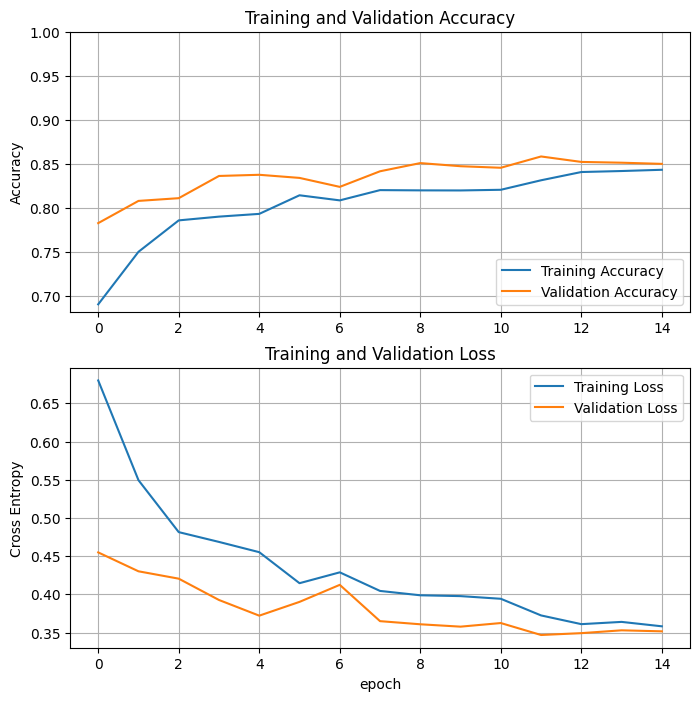

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.grid()
plt.show()

In [37]:
#Evalation on the test dataset
loss, accuracy = best_model.evaluate(test_ds)
print('Test accuracy :', accuracy)

71/71 [==============================] - 4s 60ms/step - loss: 0.3391 - accuracy: 0.8596
Test accuracy : 0.8595950603485107


Predictions:
 [0 1 1 0 1 0 0 1 0 1 0 1 1 0 0 1 1 0 0 1 0 1 1 0 1 0 1 0 1 0 0 1 0 1 0 1 1
 0 1 0 1 0 0 1 1 0 0 1 1 0 0 1 1 0 1 0 1 0 0 1 0 1 1 0]
Labels:
 [[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


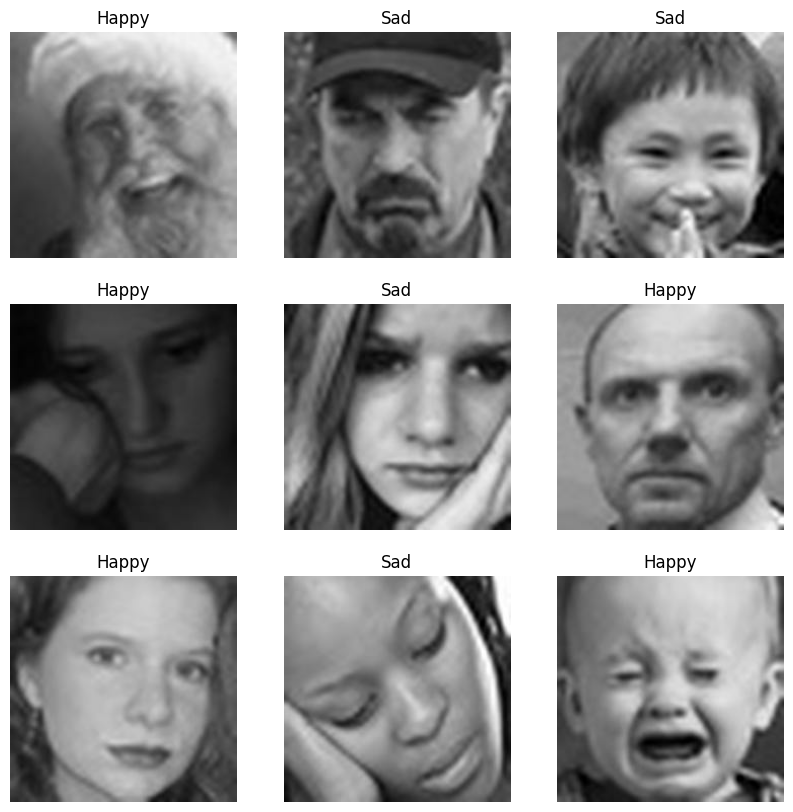

In [38]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = best_model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

Classification Report:
              precision    recall  f1-score   support

       Happy       0.89      0.88      0.88      1347
         Sad       0.83      0.84      0.83       925

    accuracy                           0.86      2272
   macro avg       0.86      0.86      0.86      2272
weighted avg       0.86      0.86      0.86      2272



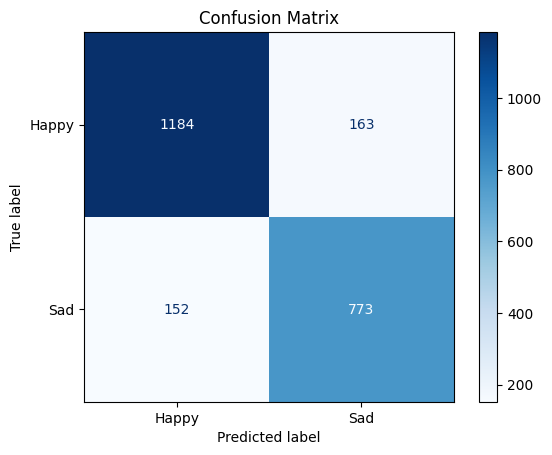

Accuracy: 0.86


In [39]:
val_labels = []
val_predictions = []

# Collect predictions and true labels
for images, labels in test_ds:
    preds = best_model.predict(images, verbose=0)
    val_labels.extend(np.argmax(labels.numpy(), axis=1))
    val_predictions.extend(np.argmax(preds, axis=1))

val_labels = np.array(val_labels)
val_predictions = np.array(val_predictions)

# Generate classification report
print("Classification Report:")

print(classification_report(val_labels, val_predictions, target_names=['Happy', 'Sad']))

# Generate confusion matrix
cm = confusion_matrix(val_labels, val_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Happy', 'Sad'])
disp.plot(cmap='Blues', values_format='d')  # Improved visuals
plt.title(f"Confusion Matrix")
plt.show()

# Calculate and display accuracy
accuracy = np.trace(cm) / np.sum(cm)
print(f"Accuracy: {accuracy:.2f}")